In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_iris

In [3]:
# Import dataset
import kagglehub

path = kagglehub.dataset_download("altruistdelhite04/loan-prediction-problem-dataset")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/altruistdelhite04/loan-prediction-problem-dataset/versions/1


In [4]:
train_path = path + "/train_u6lujuX_CVtuZ9i.csv"
test_path = path + "/test_Y3wMUE5_7gLdaTN.csv"

# Load the training data
data = pd.read_csv(train_path)

# Explore the data
print("Data Head:\n", data.head())
print("\nData Info:\n")
data.info()
print("\nData Description:\n", data.describe())

Data Head:
     Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2       

In [5]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: Loan_ID, Type: object, Unique values: 614
Column: Gender, Type: object, Unique values: 2
Column: Married, Type: object, Unique values: 2
Column: Dependents, Type: object, Unique values: 4
Column: Education, Type: object, Unique values: 2
Column: Self_Employed, Type: object, Unique values: 2
Column: ApplicantIncome, Type: int64, Unique values: 505
Column: CoapplicantIncome, Type: float64, Unique values: 287
Column: LoanAmount, Type: float64, Unique values: 203
Column: Loan_Amount_Term, Type: float64, Unique values: 10
Column: Credit_History, Type: float64, Unique values: 2
Column: Property_Area, Type: object, Unique values: 3
Column: Loan_Status, Type: object, Unique values: 2


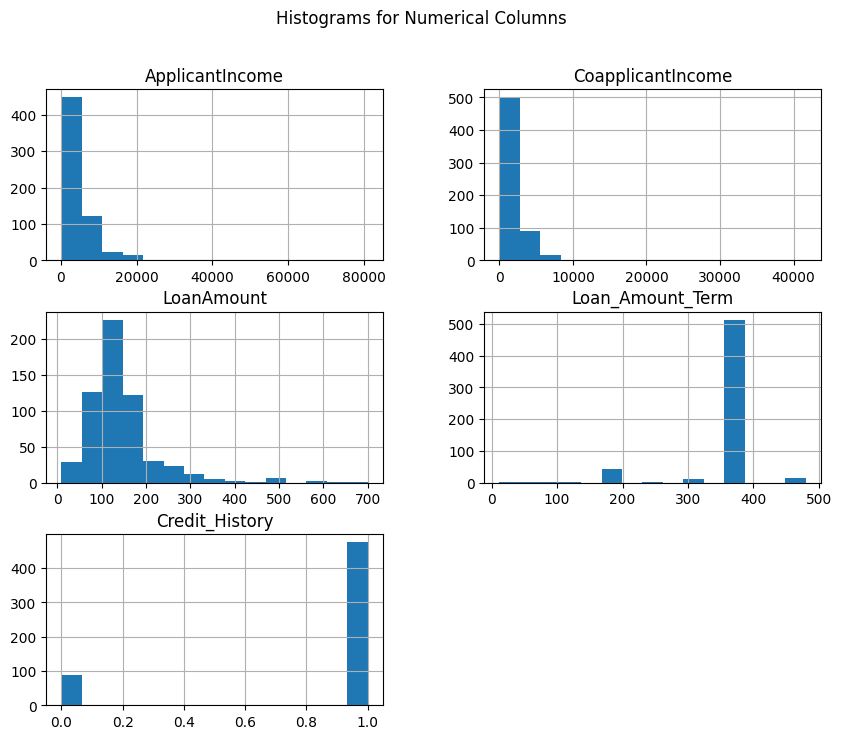

In [6]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
plt.show()


In [7]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())


Number of missing values in each column before filling:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [8]:
# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]

In [9]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)

<ipython-input-9-0fe0c4854fc3>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(mode_values_with_na[column], inplace=True)
<ipython-input-9-0fe0c4854fc3>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

In [10]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")


Values used to fill columns with missing values:
Loan_ID: LP001002
Gender: Male
Married: Yes
Dependents: 0
Education: Graduate
Self_Employed: No
ApplicantIncome: 5403.459283387622
CoapplicantIncome: 1621.2457980271008
LoanAmount: 146.41216216216216
Loan_Amount_Term: 342.0
Credit_History: 0.8421985815602837
Property_Area: Semiurban
Loan_Status: Y


In [11]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list


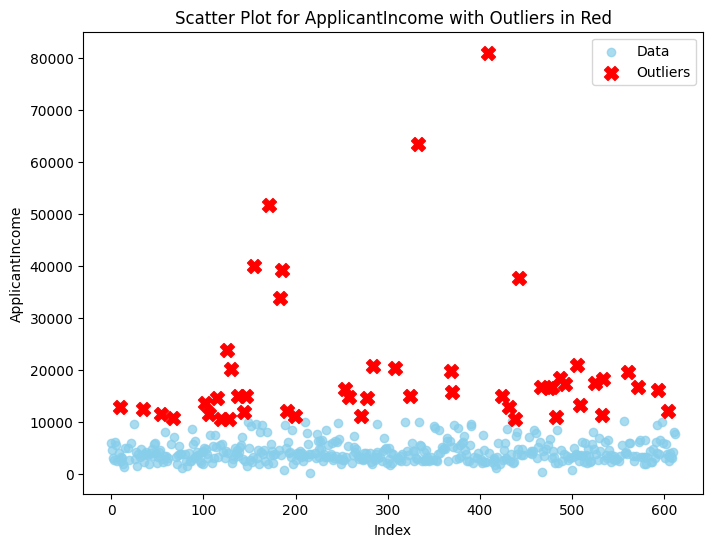


Outliers Detected for ApplicantIncome:
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
9    LP001020    Male     Yes          1      Graduate            No   
34   LP001100    Male      No         3+      Graduate            No   
54   LP001186  Female     Yes          1      Graduate           Yes   
67   LP001233    Male     Yes          1      Graduate            No   
102  LP001350    Male     Yes          0      Graduate            No   
106  LP001369    Male     Yes          2      Graduate            No   
115  LP001401    Male     Yes          1      Graduate            No   
119  LP001422  Female      No          0      Graduate            No   
126  LP001448    Male     Yes         3+      Graduate            No   
128  LP001451    Male     Yes          1      Graduate           Yes   
130  LP001469    Male      No          0      Graduate           Yes   
138  LP001492    Male      No          0      Graduate            No   
144  LP001508    Male   

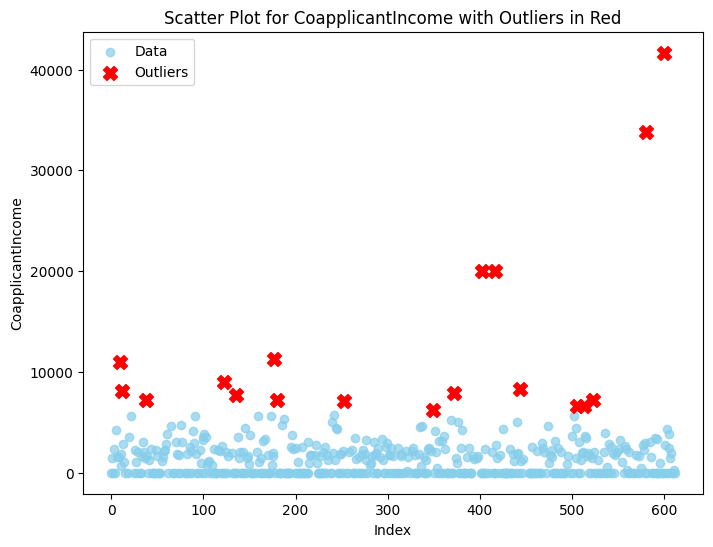


Outliers Detected for CoapplicantIncome:
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
9    LP001020    Male     Yes          1      Graduate            No   
12   LP001028    Male     Yes          2      Graduate            No   
38   LP001114    Male      No          0      Graduate            No   
122  LP001431  Female      No          0      Graduate            No   
135  LP001488    Male     Yes         3+      Graduate            No   
177  LP001610    Male     Yes         3+      Graduate            No   
180  LP001633    Male     Yes          1      Graduate            No   
253  LP001843    Male     Yes          1  Not Graduate            No   
349  LP002138    Male     Yes          0      Graduate            No   
372  LP002201    Male     Yes          2      Graduate           Yes   
402  LP002297    Male      No          0      Graduate            No   
417  LP002342    Male     Yes          2      Graduate           Yes   
444  LP002424    Male 

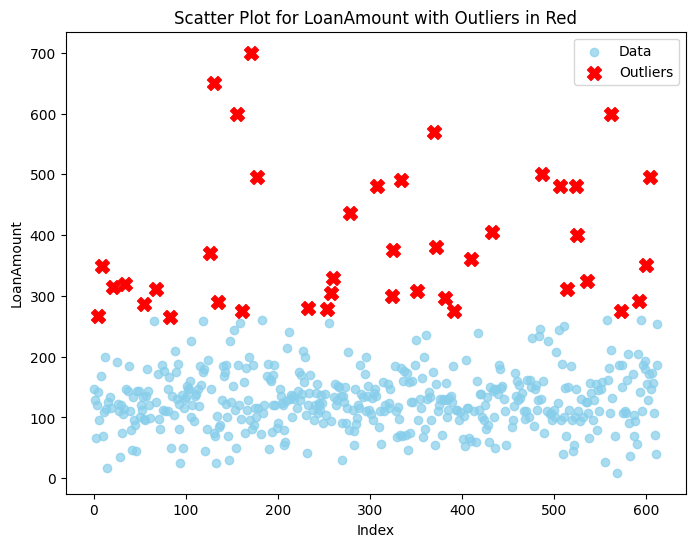


Outliers Detected for LoanAmount:
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
5    LP001011    Male     Yes          2      Graduate           Yes   
9    LP001020    Male     Yes          1      Graduate            No   
21   LP001046    Male     Yes          1      Graduate            No   
34   LP001100    Male      No         3+      Graduate            No   
54   LP001186  Female     Yes          1      Graduate           Yes   
67   LP001233    Male     Yes          1      Graduate            No   
83   LP001273    Male     Yes          0      Graduate            No   
126  LP001448    Male     Yes         3+      Graduate            No   
130  LP001469    Male      No          0      Graduate           Yes   
135  LP001488    Male     Yes         3+      Graduate            No   
155  LP001536    Male     Yes         3+      Graduate            No   
161  LP001562    Male     Yes          0      Graduate            No   
171  LP001585    Male     Yes

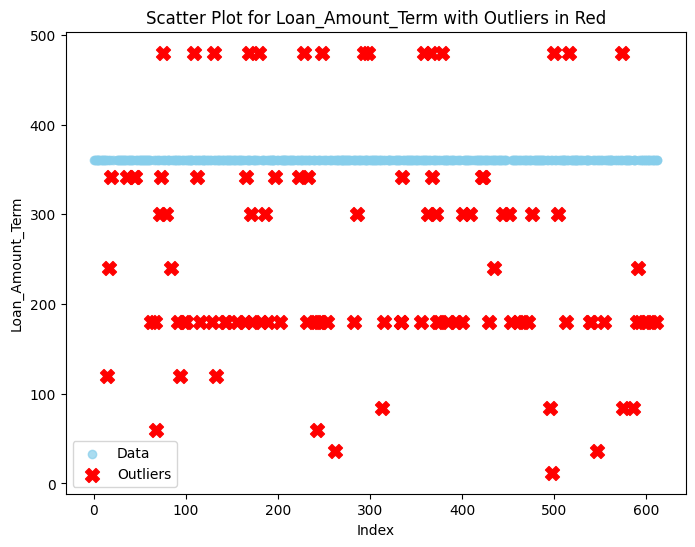


Outliers Detected for Loan_Amount_Term:
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
14   LP001030    Male     Yes          2      Graduate            No   
16   LP001034    Male      No          1  Not Graduate            No   
19   LP001041    Male     Yes          0      Graduate            No   
36   LP001109    Male     Yes          0      Graduate            No   
44   LP001136    Male     Yes          0  Not Graduate           Yes   
..        ...     ...     ...        ...           ...           ...   
591  LP002931    Male     Yes          2      Graduate           Yes   
593  LP002936    Male     Yes          0      Graduate            No   
600  LP002949  Female      No         3+      Graduate            No   
605  LP002960    Male     Yes          0  Not Graduate            No   
610  LP002979    Male     Yes         3+      Graduate            No   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
14              1299 

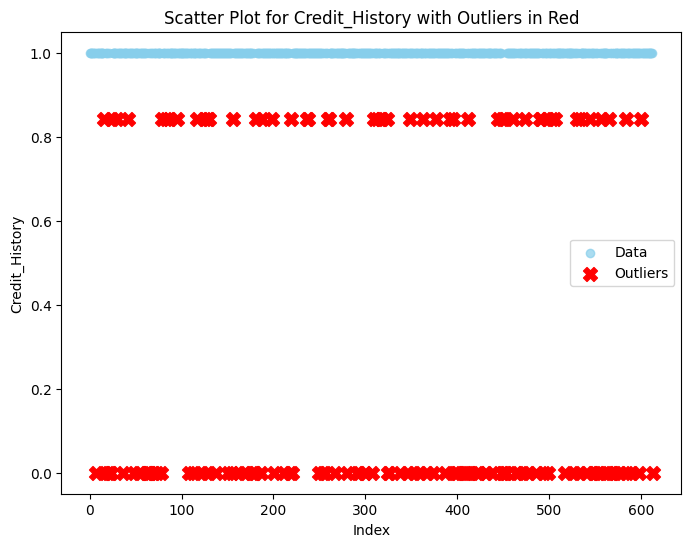


Outliers Detected for Credit_History:
      Loan_ID  Gender Married Dependents     Education Self_Employed  \
7    LP001014    Male     Yes         3+      Graduate            No   
16   LP001034    Male      No          1  Not Graduate            No   
17   LP001036  Female      No          0      Graduate            No   
20   LP001043    Male     Yes          0  Not Graduate            No   
22   LP001047    Male     Yes          0  Not Graduate            No   
..        ...     ...     ...        ...           ...           ...   
584  LP002911    Male     Yes          1      Graduate            No   
589  LP002926    Male     Yes          2      Graduate           Yes   
597  LP002943    Male      No          0      Graduate            No   
600  LP002949  Female      No         3+      Graduate            No   
613  LP002990  Female      No          0      Graduate           Yes   

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
7               3036   

In [12]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    plt.show()

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

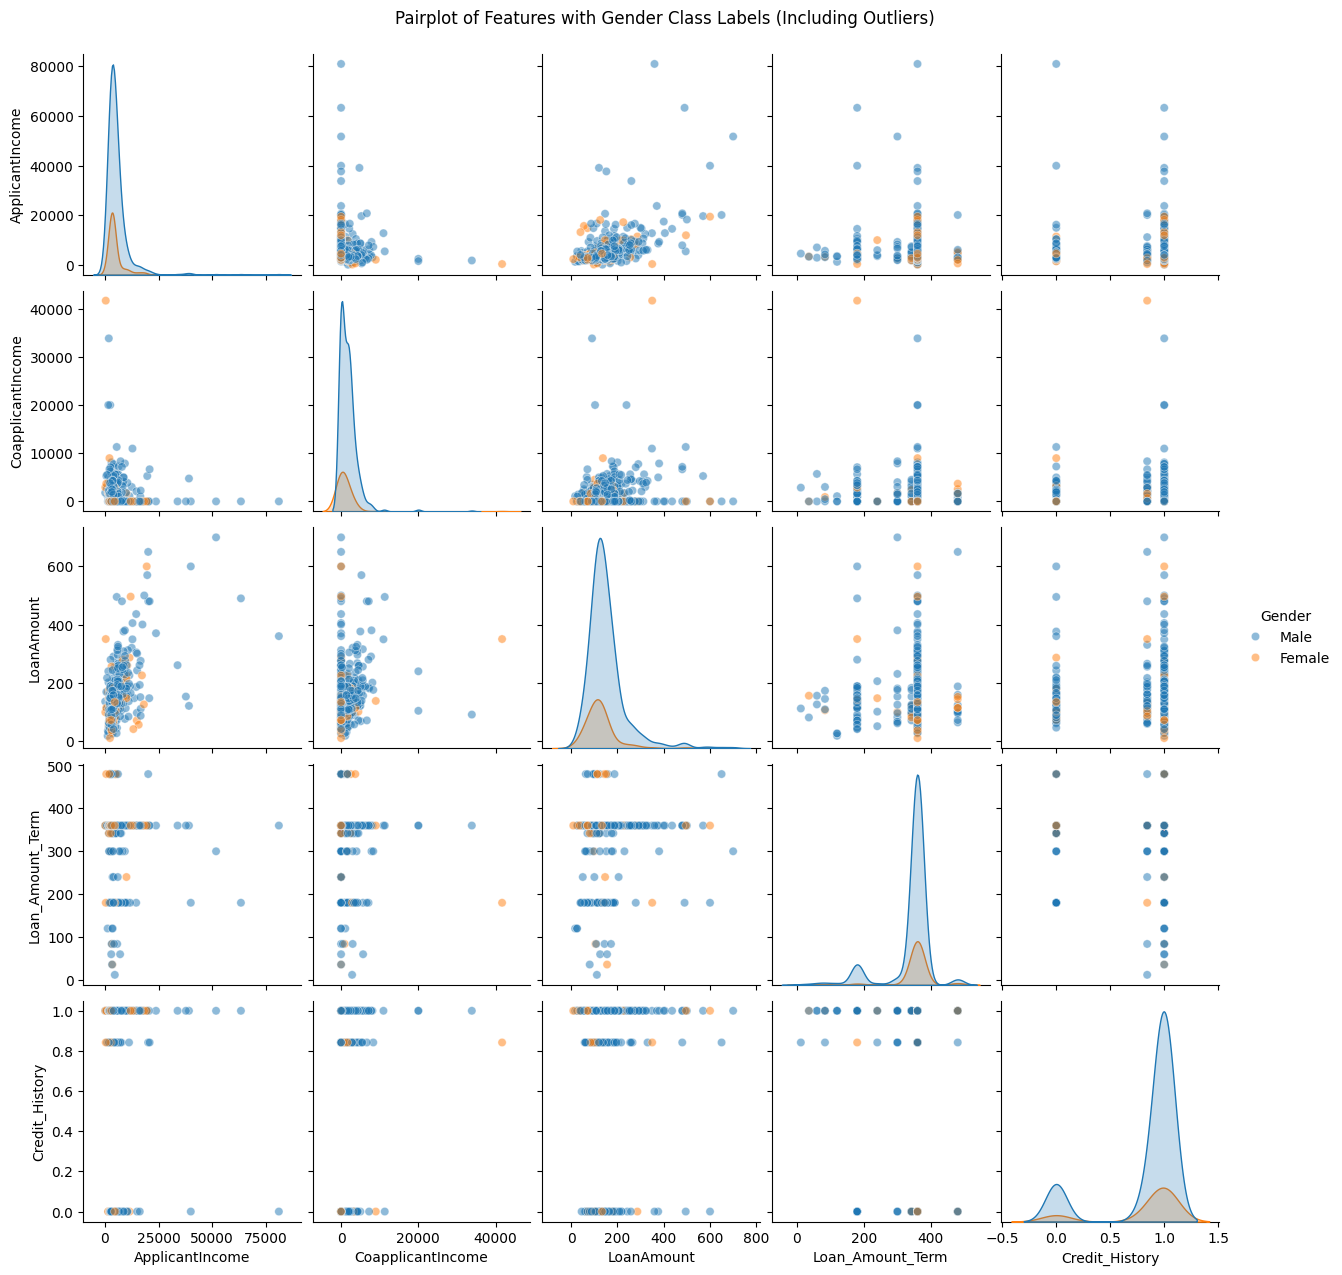

In [13]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Gender', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Gender Class Labels (Including Outliers)", y=1.02)
plt.show()

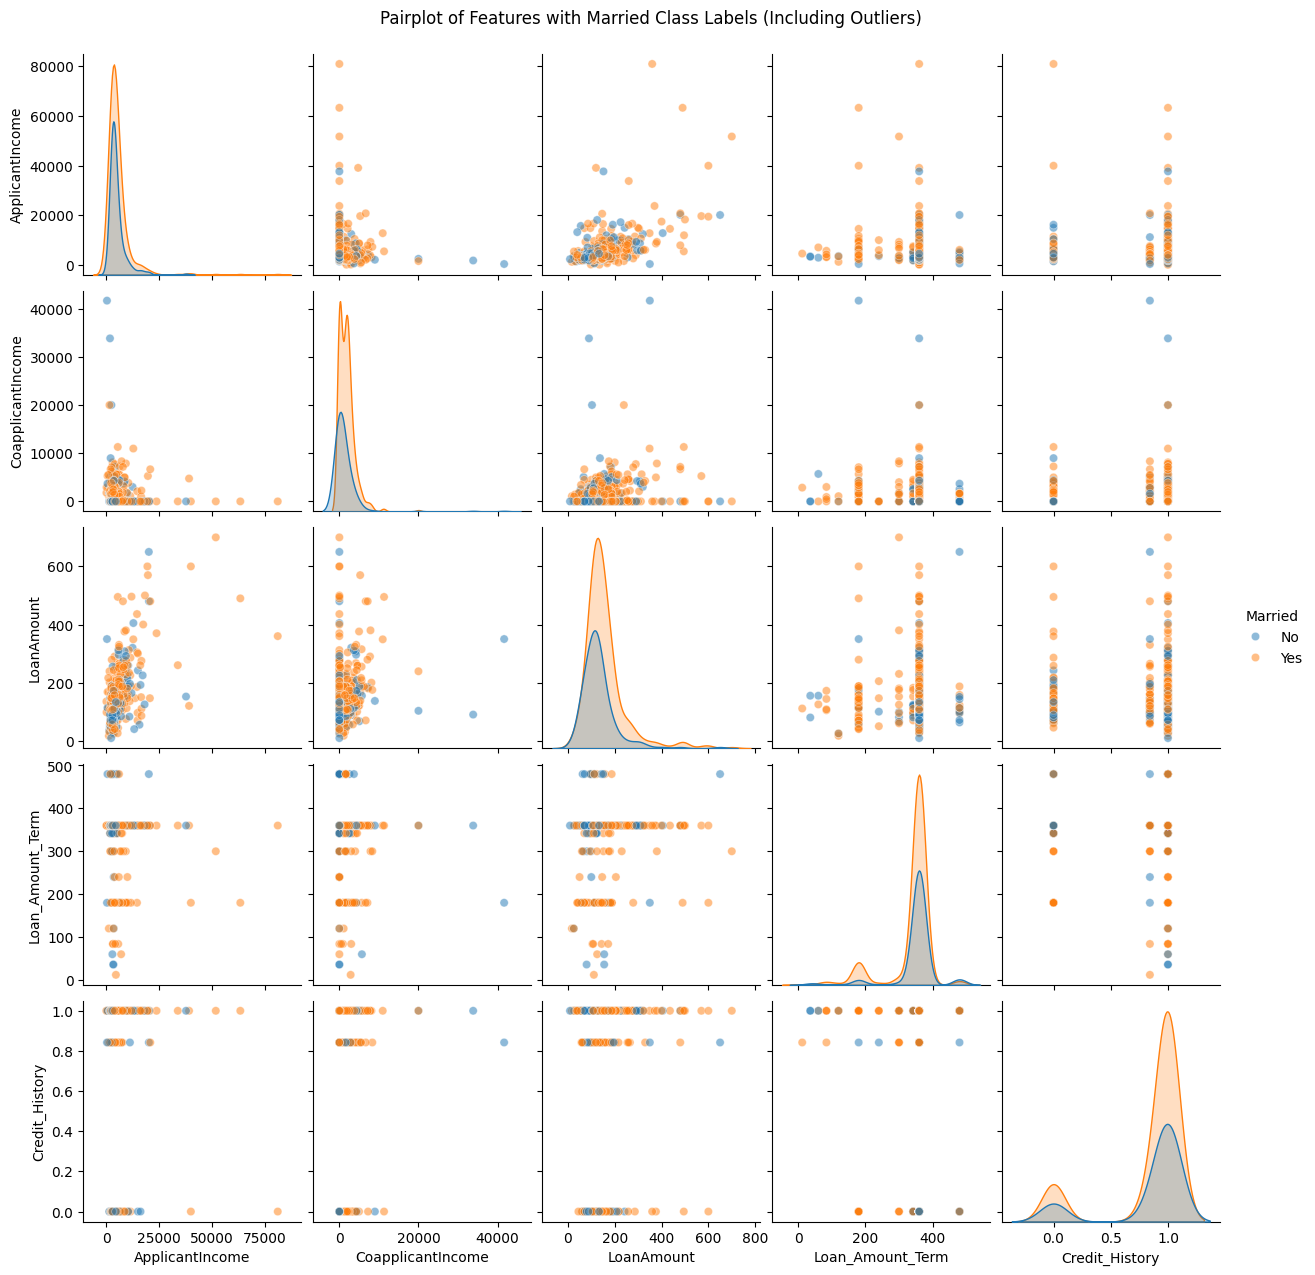

In [14]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Married', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Married Class Labels (Including Outliers)", y=1.02)
plt.show()

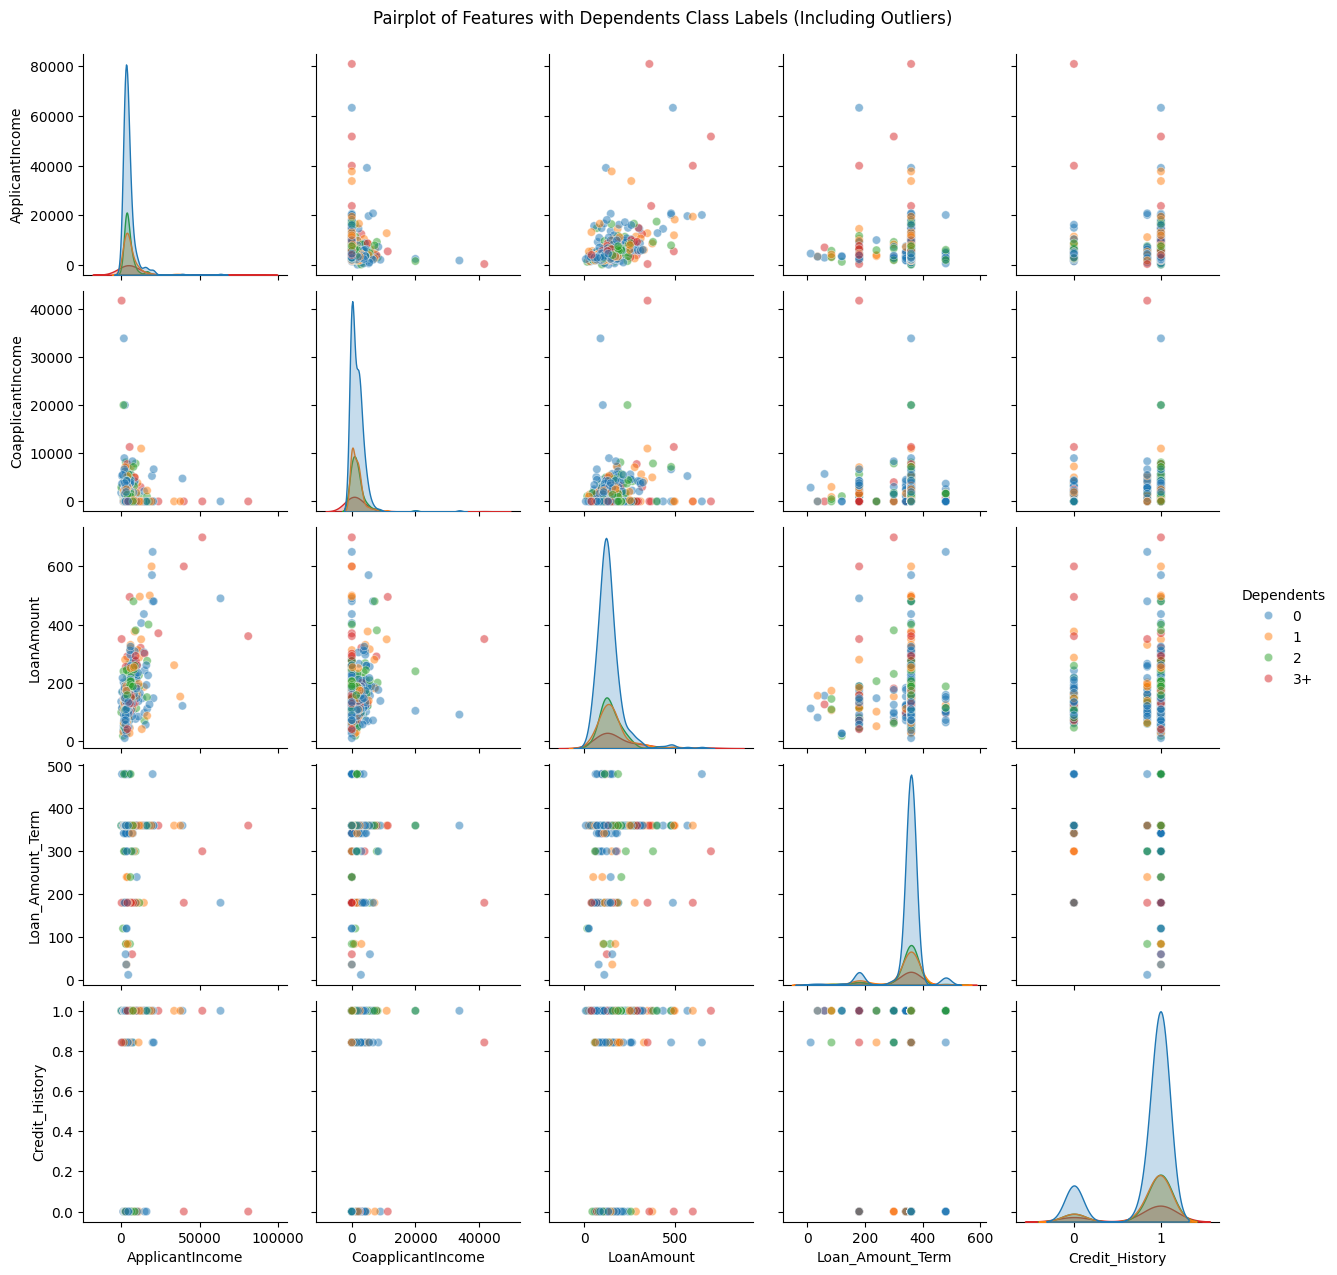

In [15]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Dependents', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Dependents Class Labels (Including Outliers)", y=1.02)
plt.show()

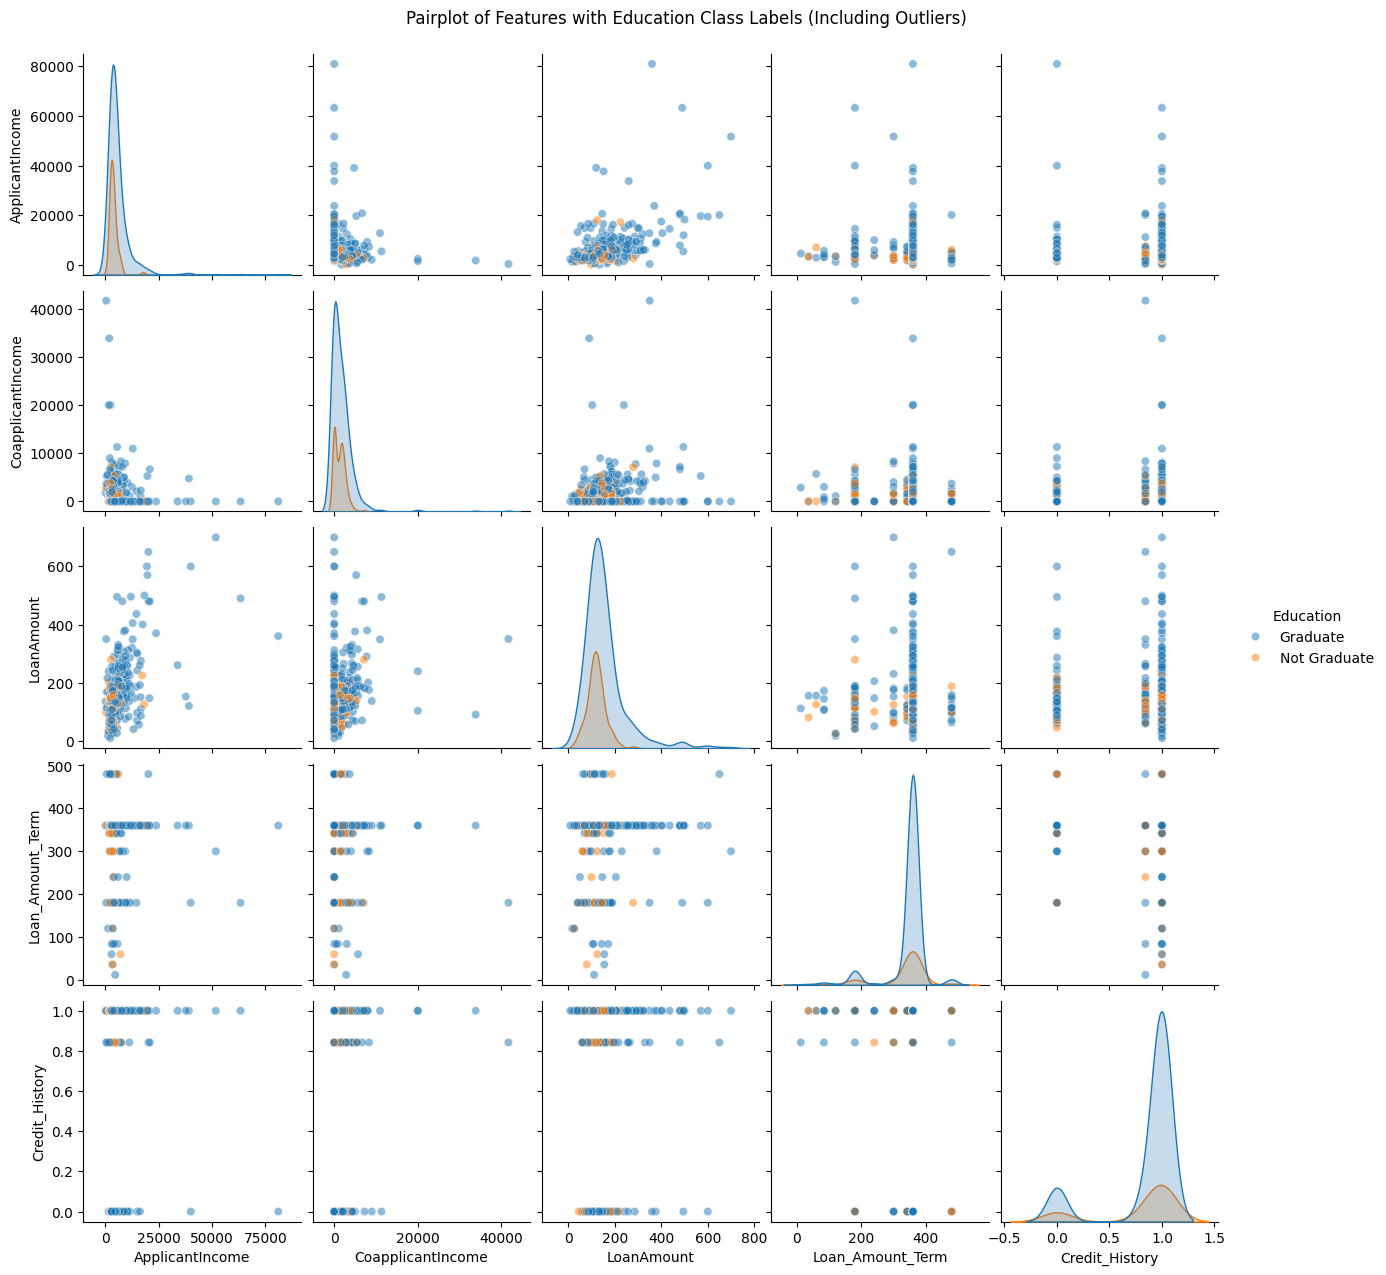

In [16]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Education', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Education Class Labels (Including Outliers)", y=1.02)
plt.show()


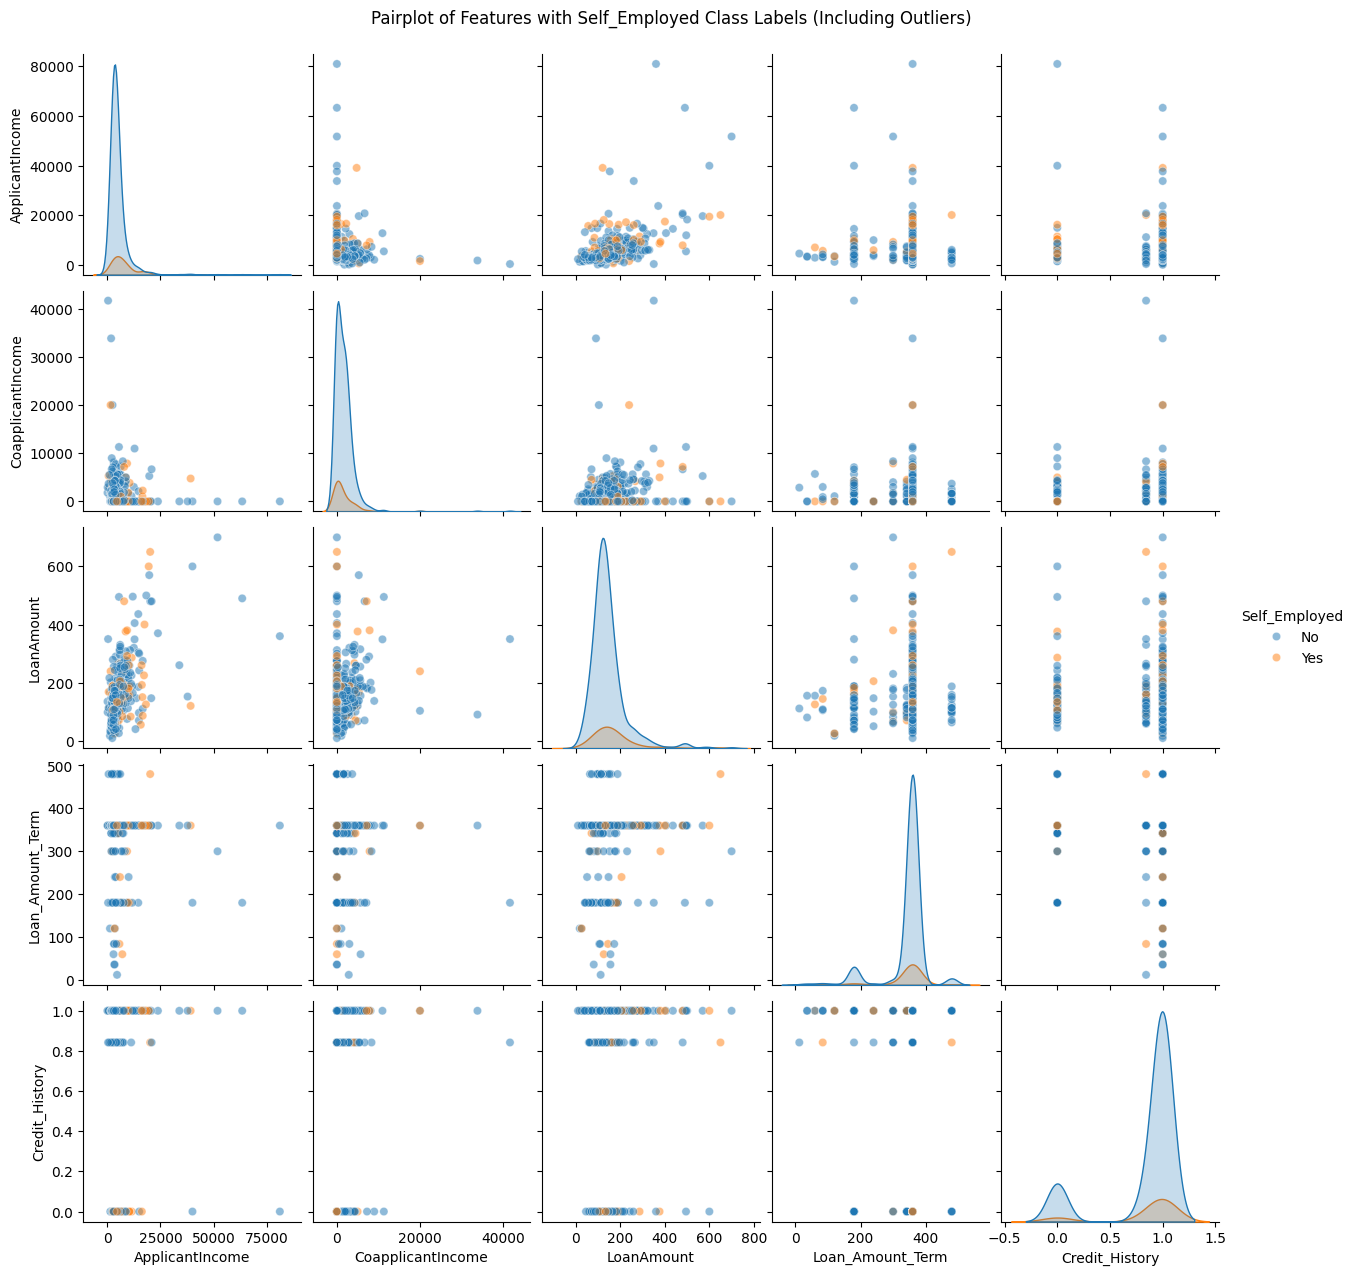

In [17]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='Self_Employed', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Self_Employed Class Labels (Including Outliers)", y=1.02)
plt.show()

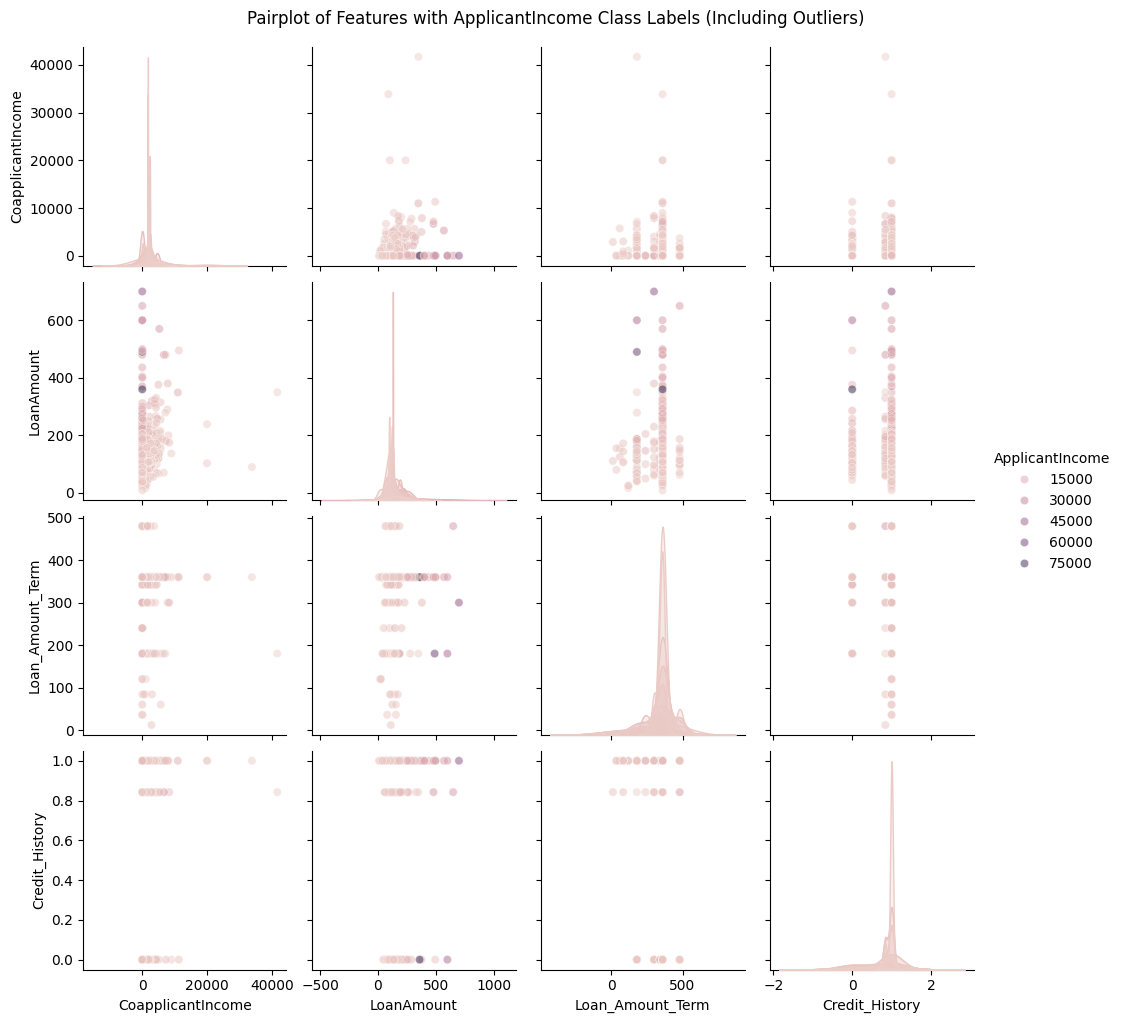

In [18]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='ApplicantIncome', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with ApplicantIncome Class Labels (Including Outliers)", y=1.02)
plt.show()

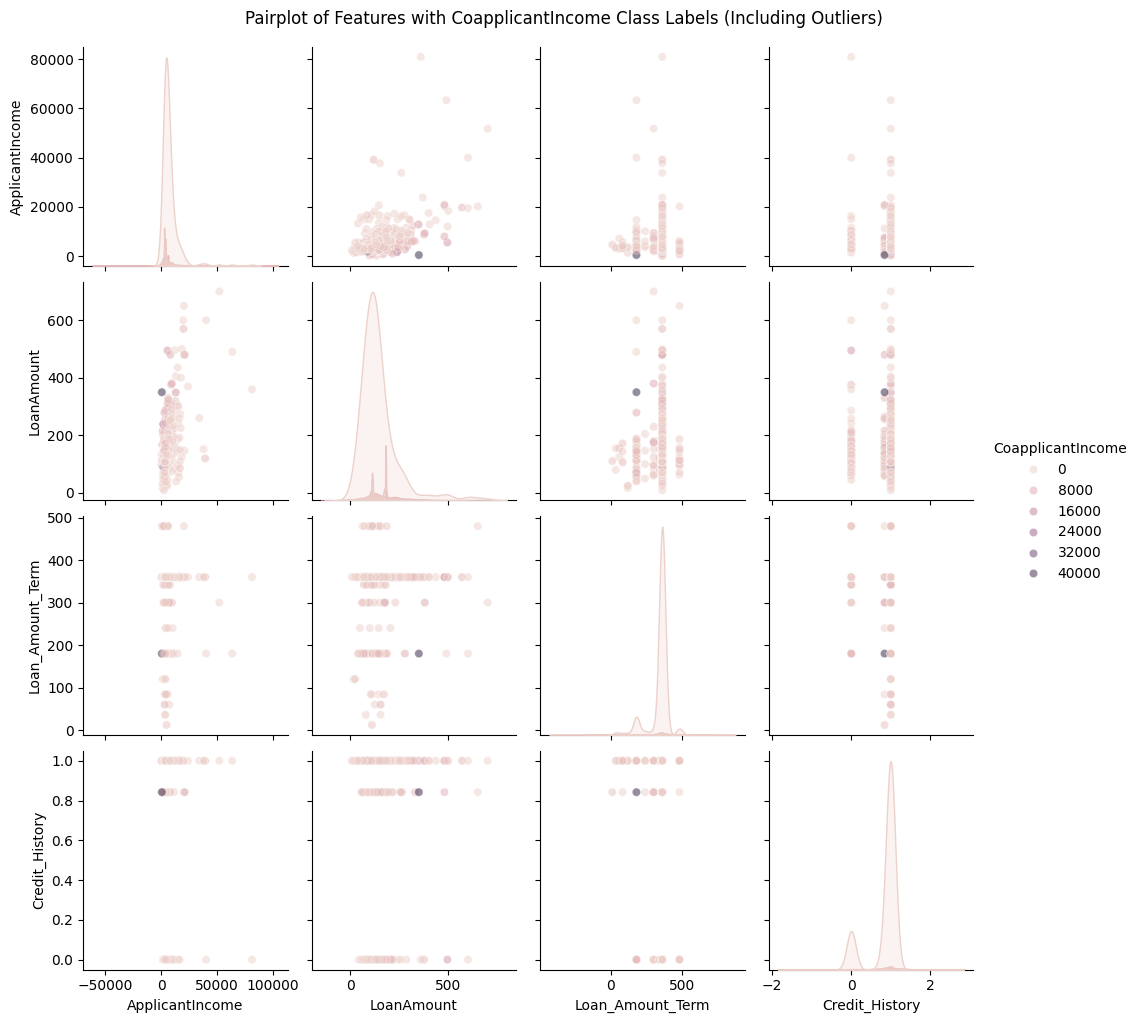

In [19]:
# Visualize the original data with a pairplot (including outliers)
sns.pairplot(data, hue='CoapplicantIncome', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with CoapplicantIncome Class Labels (Including Outliers)", y=1.02)
plt.show()

In [20]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data = cleaned_data[~cleaned_data.index.isin(outliers.index)]  # Remove rows with outliers


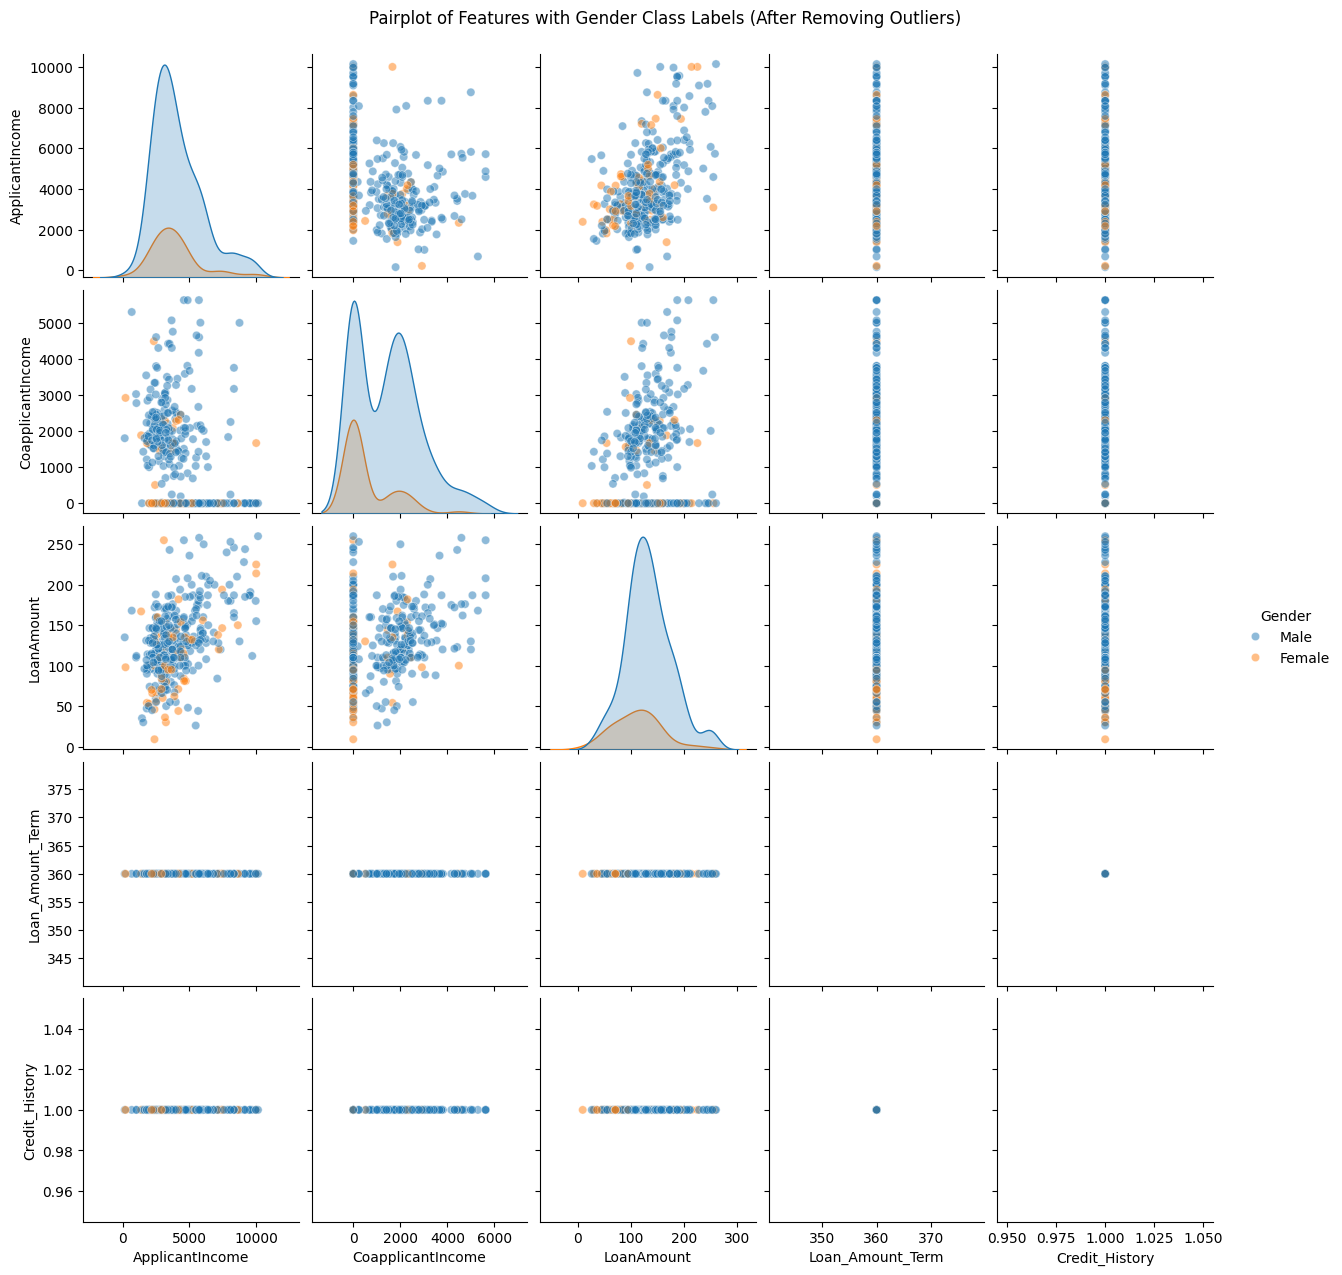

In [21]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Gender', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Gender Class Labels (After Removing Outliers)", y=1.02)
plt.show()

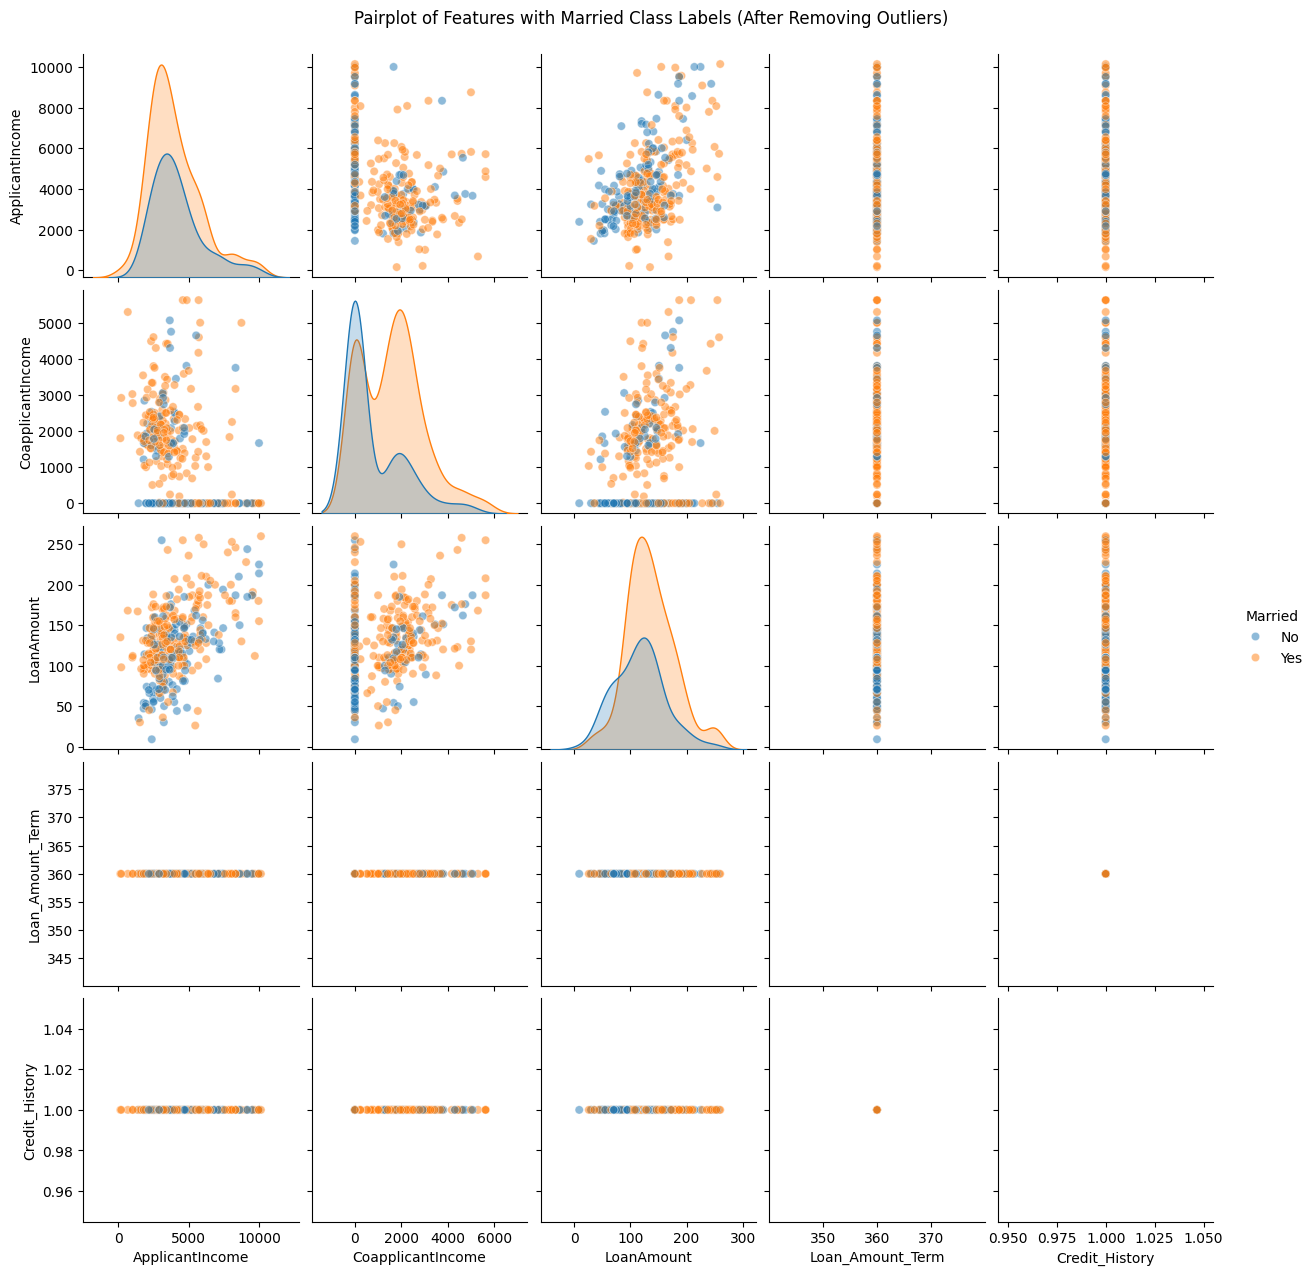

In [22]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Married', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Married Class Labels (After Removing Outliers)", y=1.02)
plt.show()

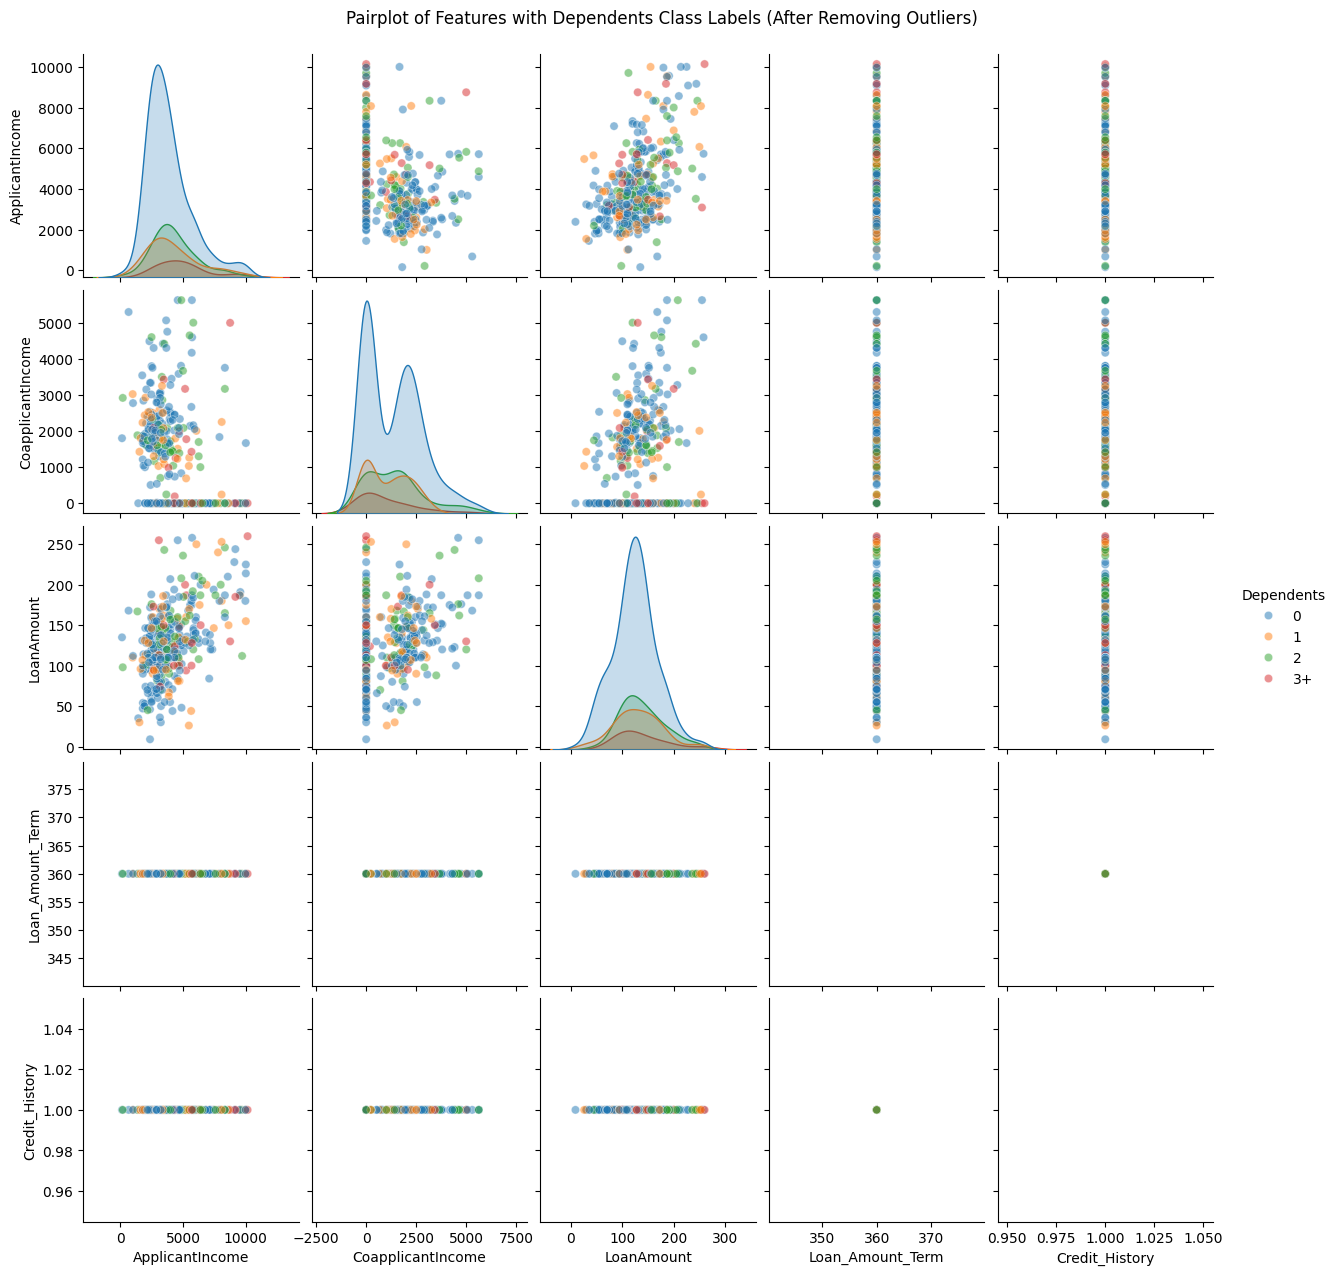

In [23]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Dependents', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Dependents Class Labels (After Removing Outliers)", y=1.02)
plt.show()

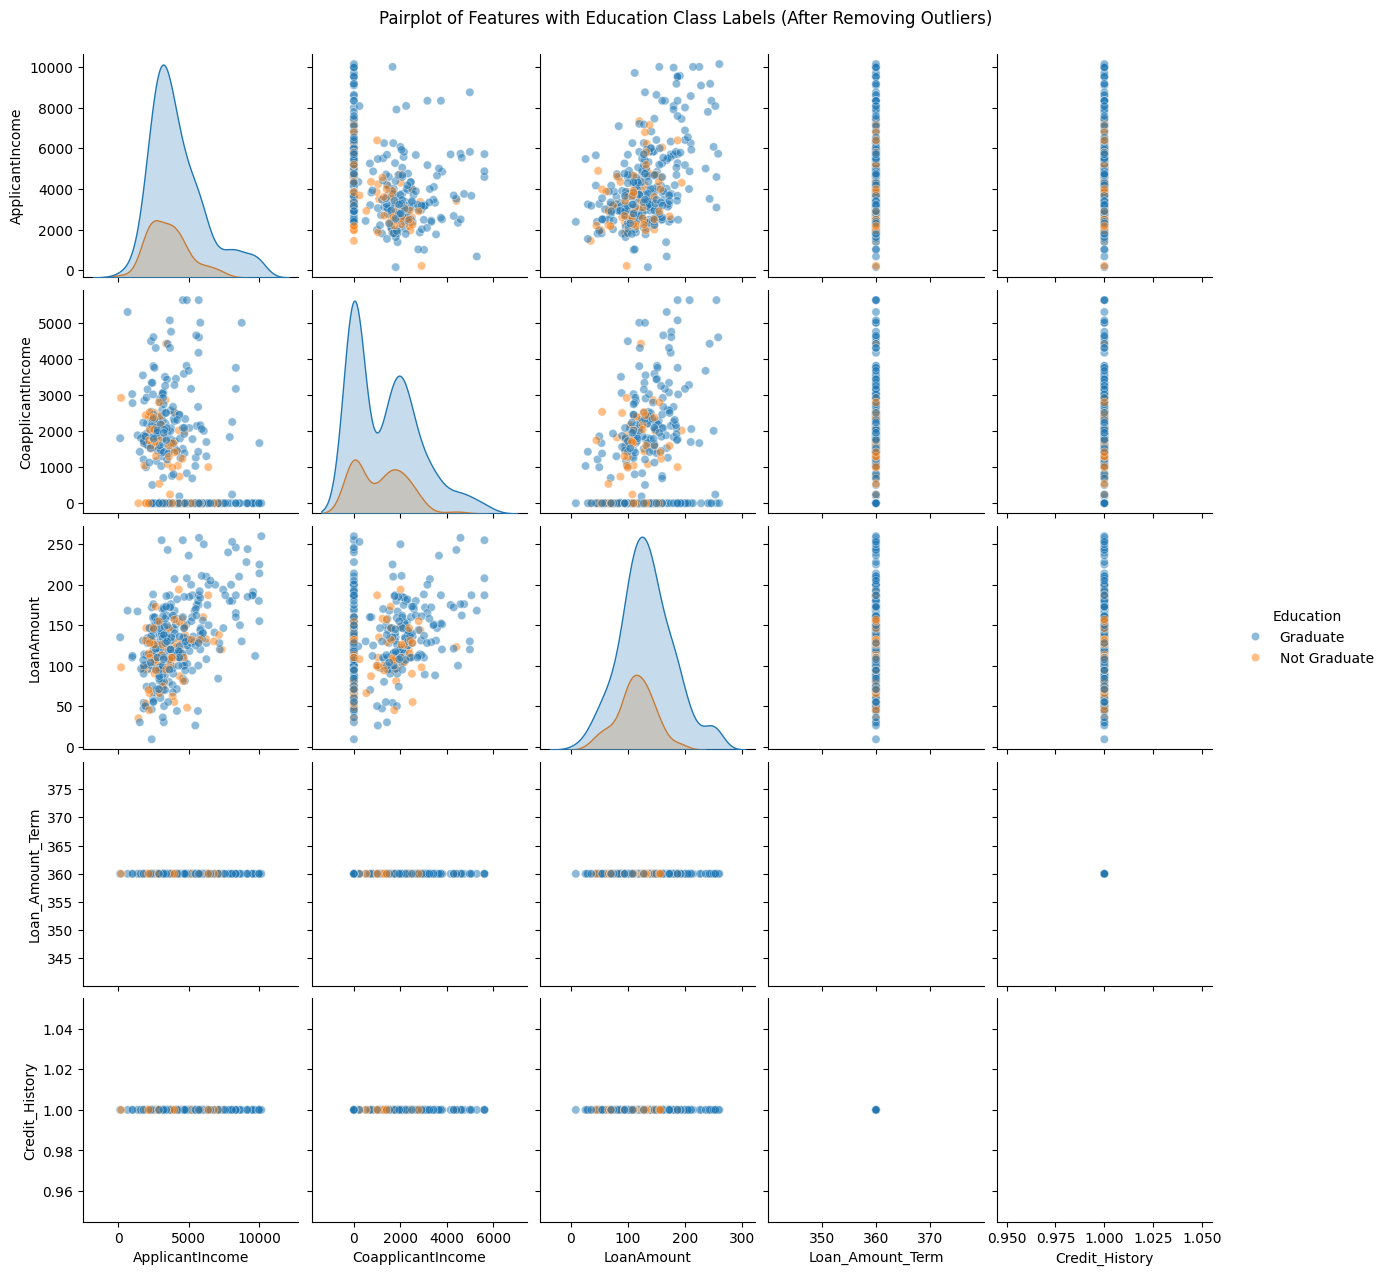

In [24]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Education', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Education Class Labels (After Removing Outliers)", y=1.02)
plt.show()

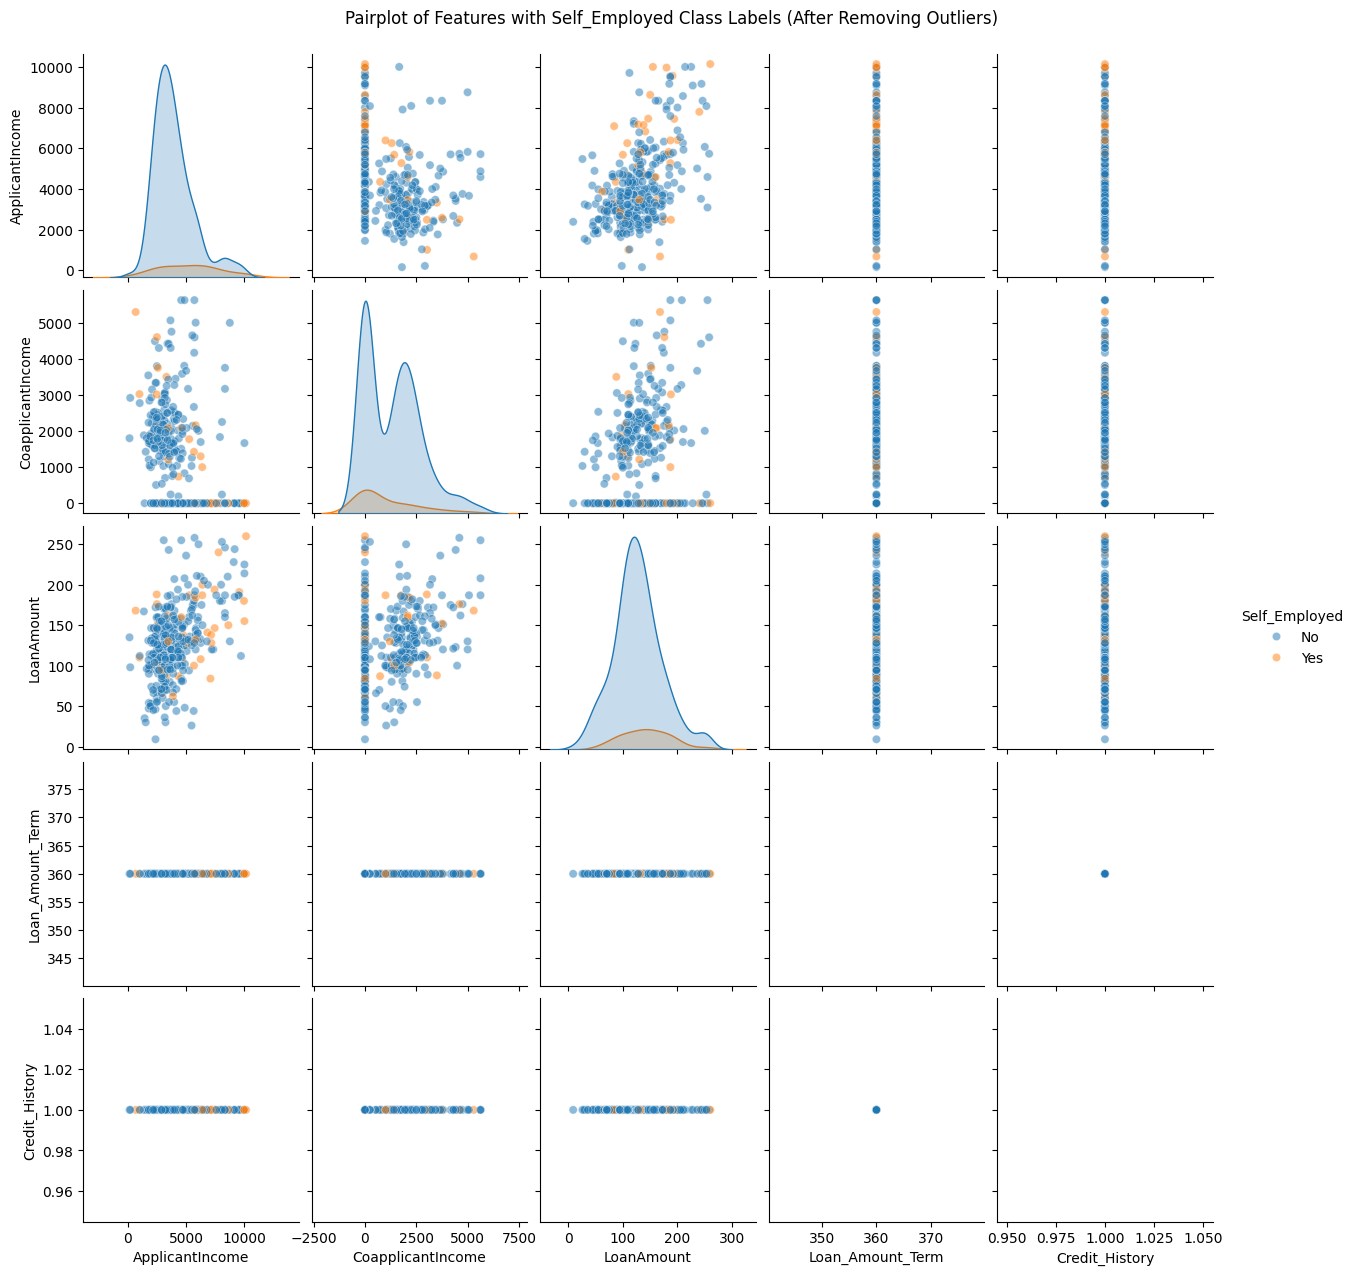

In [25]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='Self_Employed', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with Self_Employed Class Labels (After Removing Outliers)", y=1.02)
plt.show()


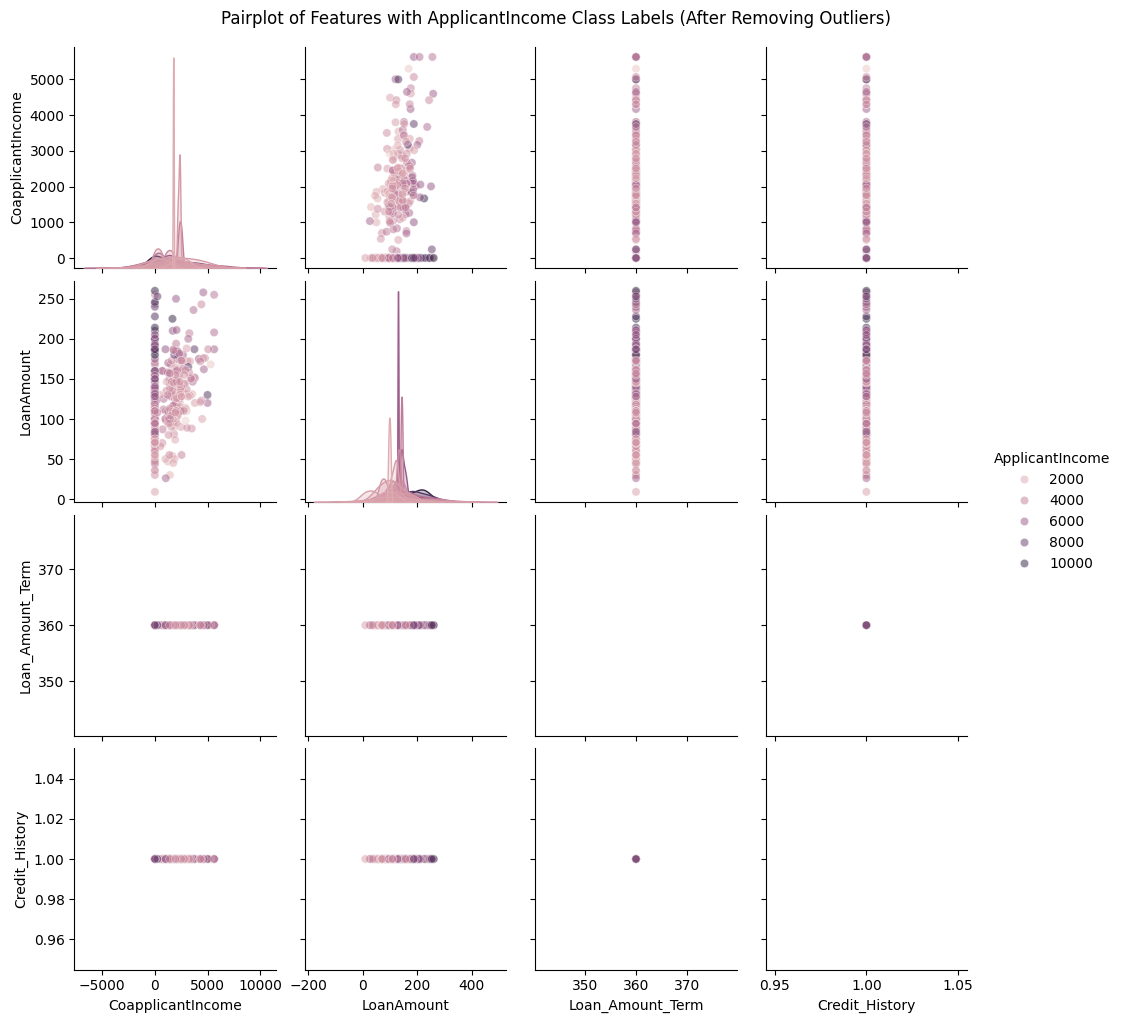

In [26]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='ApplicantIncome', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with ApplicantIncome Class Labels (After Removing Outliers)", y=1.02)
plt.show()


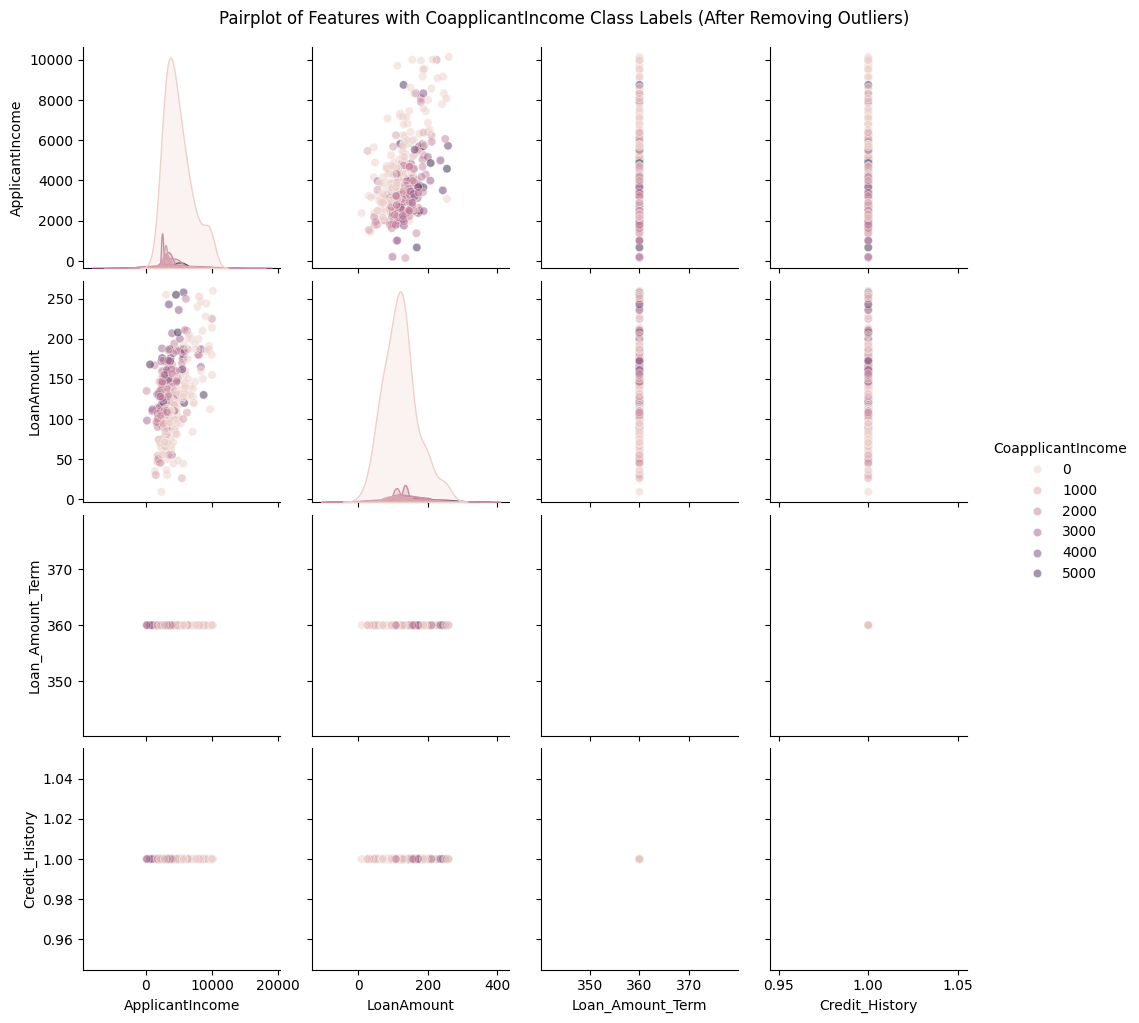

In [27]:
# Visualize the cleaned data with a pairplot (after removing outliers)
sns.pairplot(cleaned_data, hue='CoapplicantIncome', plot_kws={'alpha': 0.5})
plt.suptitle("Pairplot of Features with CoapplicantIncome Class Labels (After Removing Outliers)", y=1.02)
plt.show()

In [28]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['Loan_Status'] = label_encoder.fit_transform(data['Loan_Status'])

In [29]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'Loan_Status')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'Loan_Status':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

In [30]:
# Step 10: Define features (X) and target (y)

X = data.drop(columns=['Loan_Status'])  # Features
y = data['Loan_Status']  # Target variable

In [31]:
# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [34]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

LogisticRegression()

In [35]:
# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [36]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [37]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [38]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

In [39]:
# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)


In [40]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


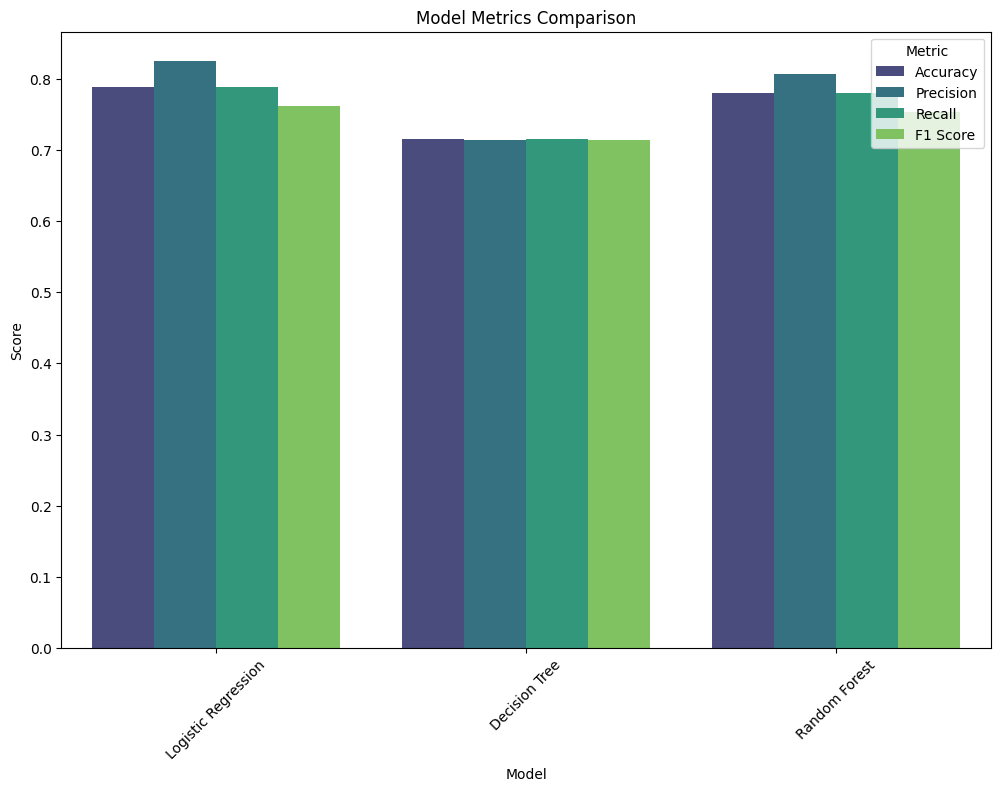

In [41]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.show()

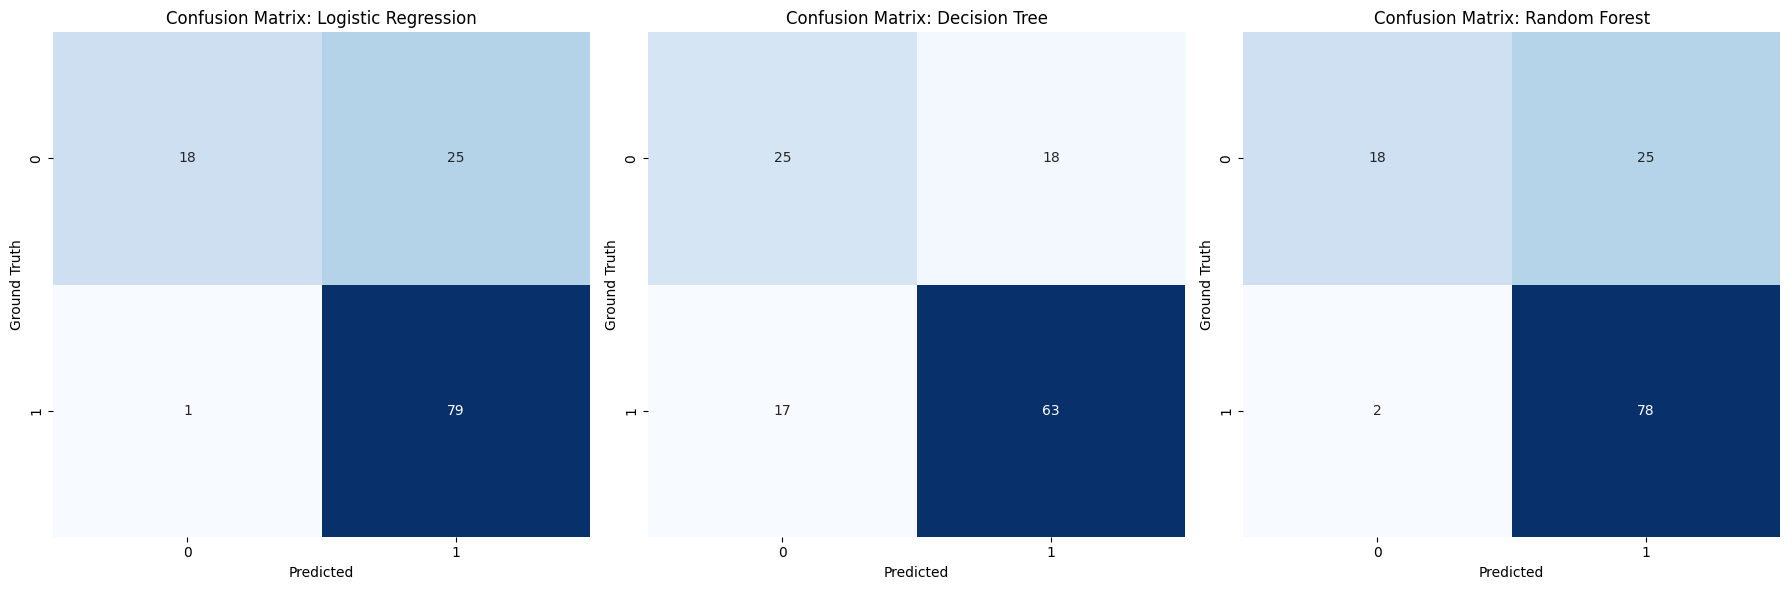

In [42]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
plt.show()

In [43]:
# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59        43
           1       0.78      0.79      0.78        80

    accuracy                           0.72       123
   macro avg       0.69      0.68      0.69       123
weighted avg       0.71      0.72      0.71       123


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       